# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




ModuleNotFoundError: No module named 'scipy'

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [ ]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [ ]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>

SELECT ?ace
       (MAX(?label) AS ?label)
       (xsd:integer(MAX(?birthDate)) AS ?birthYear)
       (GROUP_CONCAT(DISTINCT ?allegLabel; separator=", ") AS ?allegiances)
       (GROUP_CONCAT(DISTINCT ?awardLabel; separator=", ") AS ?awards)
       (COUNT(DISTINCT ?award) AS ?nbAwards)
       (MAX(?birthCountryLabel) AS ?birthCountry)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {

    ?ace rdfs:label ?label ;
         wdt:P569 ?birthDate .

    OPTIONAL {
      ?ace wdt:P945 ?allegiance .
      OPTIONAL { ?allegiance rdfs:label ?allegLabel . }
    }

    OPTIONAL {
      ?ace wdt:P166 ?award .
      OPTIONAL { ?award rdfs:label ?awardLabel . }
    }

    OPTIONAL {
      ?ace wdt:P19 ?placeOfBirth .
      OPTIONAL {
        ?placeOfBirth wdt:P17 ?birthCountry .
        OPTIONAL { ?birthCountry rdfs:label ?birthCountryLabel . }
      }
    }
  }
}
GROUP BY ?ace
ORDER BY ?birthYear
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

23684


[['http://www.wikidata.org/entity/Q97193482',
  'Q97193482',
  '1941',
  'male',
  'Ukraine, Soviet Union',
  'Europe, Asia',
  'physicist',
  ''],
 ['http://www.wikidata.org/entity/Q4511380',
  'Anita Goel',
  '1973',
  'female',
  'United States, India',
  'North America, Asia',
  'physicist, biophysicist',
  ''],
 ['http://www.wikidata.org/entity/Q4706857',
  'Alan Herries Wilson',
  '1906',
  'male',
  'United Kingdom',
  'Europe',
  'physicist, mathematician',
  '']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"United States, Israel, Canada","North America, Asia","academic, physicist","nuclear physics, cosmology, general relativity"
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",


In [9]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [10]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23684 entries, 0 to 23683
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    23684 non-null  object
 1   personLabel  23684 non-null  object
 2   birthYear    23684 non-null  int64 
 3   gender       23684 non-null  object
 4   countries    23684 non-null  object
 5   continents   23684 non-null  object
 6   occupations  23684 non-null  object
 7   fields       23684 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.4+ MB


In [11]:
### Store to CSV
f_path = 'data/df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [12]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Europe, Asia
1    North America, Asia
2                 Europe
3    North America, Asia
4                 Europe
Name: continents, dtype: object


In [13]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                          0
continents                                 
Europe                                13343
North America                          4248
Asia                                   2055
Europe, Asia                           1582
South America                           389
North America, Europe                   319
Oceania                                 288
Europe, Asia, North America, Eurasia    265
Asia, Europe                            246
Africa                                  139


In [14]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [15]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [16]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe


In [17]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Africa             150
Oceania            302
SouthAmerica       389
Asia              2055
Eurasia           2121
NorthAmerica      4353
Europe           14314


In [18]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
12,http://www.wikidata.org/entity/Q60167219,Yuri Golembiovsky,1937,male,Russia,Europe,"physicist, teacher, engineer",,Europe
20,http://www.wikidata.org/entity/Q52195429,Konstantin Iosifovich Gringauz,1918,male,"Russia, Soviet Union","Europe, Asia",physicist,"astrophysics, plasma physics",Eurasia
32,http://www.wikidata.org/entity/Q4095524,Pyotr Boyarsky,1943,male,"Soviet Union, Russia","Europe, Asia","executive, historian, writer, geographer, edit...","research expedition, polar expedition, polar r...",Eurasia
42,http://www.wikidata.org/entity/Q29363866,Joseph Poliakoff,1873,male,"Russian Empire, United Kingdom, United Kingdom...","North America, Eurasia, Europe","inventor, physicist, engineer",,Europe
45,http://www.wikidata.org/entity/Q12103107,Amos Diachenko,1814,male,Russian Empire,"North America, Eurasia","astronomer, mathematician","astronomy, theory of differential equations, m...",Eurasia
66,http://www.wikidata.org/entity/Q92949648,Q92949648,1909,male,"Soviet Union, Russia","Europe, Asia","university teacher, physicist",mathematics,Eurasia
84,http://www.wikidata.org/entity/Q60832387,Dmitry Mishin,1919,male,"Soviet Union, Russia, Russian State","Europe, Asia, Eurasia","university teacher, physicist",physics,Eurasia


In [19]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Europe         653
Eurasia       1441


In [20]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q2573136,Wilhelm Heinrich Heraeus,1900,male,Germany,Europe,"physicist, entrepreneur, chemist",,Europe
98,http://www.wikidata.org/entity/Q1730238,Karl Albert Hasselbalch,1874,male,Kingdom of Denmark,Europe,"physicist, chemist",,Europe
99,http://www.wikidata.org/entity/Q4131361,Andrey Gagarin,1856,male,"Russian Soviet Federative Socialist Republic, ...","Eurasia, North America","engineer, mathematician, pedagogue",physics,Eurasia
100,http://www.wikidata.org/entity/Q107844507,Stefania Gori,1983,female,Italy,Europe,physicist,,Europe


In [21]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q4511457,Luise Meyer-Schützmeister,1915,female,Germany,Europe,"physicist, nuclear physicist",,Europe
112,http://www.wikidata.org/entity/Q57024819,Hannes Pichler,1986,male,"Italy, Austria",Europe,"researcher, physicist",,Europe
113,http://www.wikidata.org/entity/Q126718262,Zhou Lian,1940,male,People's Republic of China,Asia,"researcher, physicist",,Asia
114,http://www.wikidata.org/entity/Q7085825,Ole Colbjørnsen,1897,male,Norway,Europe,"physicist, journalist, politician, economist",,Europe
115,http://www.wikidata.org/entity/Q59624350,Alberto Carlini,1965,male,Italy,Europe,physicist,,Europe
116,http://www.wikidata.org/entity/Q95361999,František Doutlík,1880,male,Czechoslovakia,Europe,"teacher, chronicler, musician","astronomy, educational system",Europe
117,http://www.wikidata.org/entity/Q17119374,Eliza Wilbur,1851,female,United States,North America,"inventor, astronomer",,NorthAmerica


In [22]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  436 

94      http://www.wikidata.org/entity/Q72055
99    http://www.wikidata.org/entity/Q4131361
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
94,http://www.wikidata.org/entity/Q72055,Albrecht Wellmer,1933,male,Germany,Europe,"sociologist, university teacher, philosopher","mathematics, physics",Europe
99,http://www.wikidata.org/entity/Q4131361,Andrey Gagarin,1856,male,"Russian Soviet Federative Socialist Republic, ...","Eurasia, North America","engineer, mathematician, pedagogue",physics,Eurasia
116,http://www.wikidata.org/entity/Q95361999,František Doutlík,1880,male,Czechoslovakia,Europe,"teacher, chronicler, musician","astronomy, educational system",Europe
128,http://www.wikidata.org/entity/Q4444381,Vladimir Strunin,1953,male,Russia,Europe,scientist,physics,Europe
154,http://www.wikidata.org/entity/Q114191385,Q114191385,1946,male,"Soviet Union, Belarus","Europe, Asia","scientist, university teacher","optics, physics",Eurasia


### Distribution des continents: représentation graphique

In [23]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Africa,150,0.63
Oceania,302,1.28
SouthAmerica,389,1.64
Asia,2055,8.68
Eurasia,2121,8.96
NorthAmerica,4353,18.38
Europe,14314,60.44


In [24]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Eurasia,Asia,SouthAmerica,Oceania,Africa
frequence,60.44,18.38,8.96,8.68,1.64,1.28,0.63


In [25]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


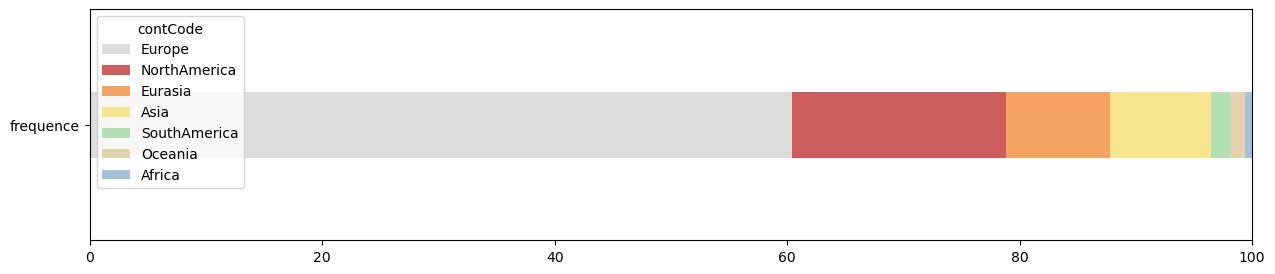

In [26]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [27]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [28]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [29]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925


In [30]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1751-1775     252
1776-1800     328
1801-1825     534
1826-1850     811
1851-1875    1312
1876-1900    1918
1901-1925    4215
1926-1950    8133
1951-1975    4959
1976-2000    1222
dtype: int64


### Comparer période et continent

In [31]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,0,8,10,229,4,0,1,252
1776-1800,1,3,18,286,17,2,1,328
1801-1825,2,7,28,445,47,2,3,534
1826-1850,2,6,63,630,97,8,5,811
1851-1875,5,24,105,940,201,25,12,1312
1876-1900,7,83,135,1335,329,17,12,1918
1901-1925,19,366,498,2160,1041,72,59,4215
1926-1950,40,885,1000,4348,1606,106,148,8133
1951-1975,46,565,253,3109,816,59,111,4959


In [32]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,229,10,4,8,0,0,1,252
1776-1800,286,18,17,3,1,2,1,328
1801-1825,445,28,47,7,2,2,3,534
1826-1850,630,63,97,6,2,8,5,811
1851-1875,940,105,201,24,5,25,12,1312
1876-1900,1335,135,329,83,7,17,12,1918
1901-1925,2160,498,1041,366,19,72,59,4215
1926-1950,4348,1000,1606,885,40,106,148,8133
1951-1975,3109,253,816,565,46,59,111,4959


In [33]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


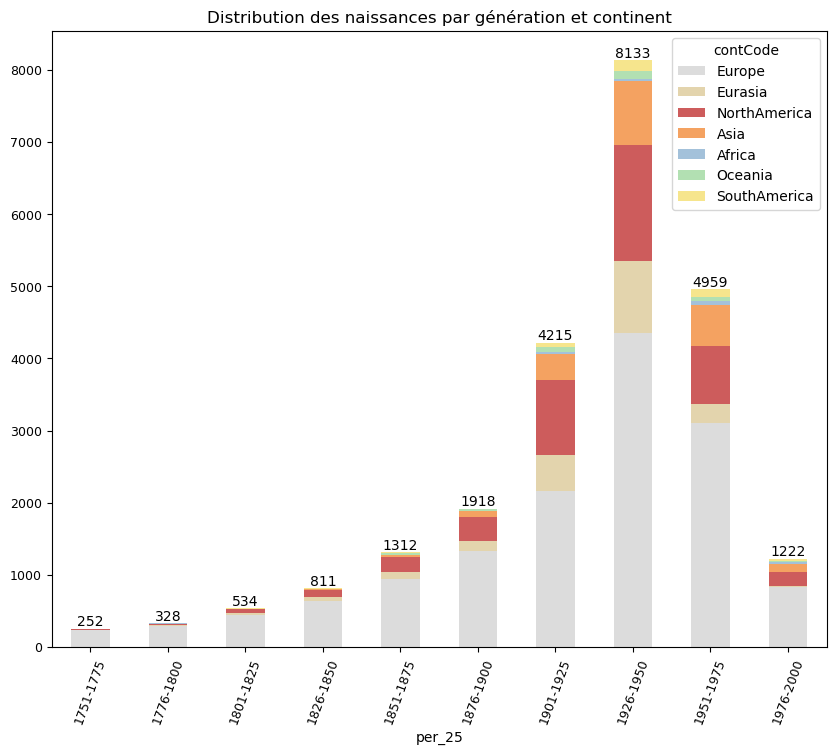

In [34]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [35]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,229,10,4,8,0,0,1,252
1776-1800,286,18,17,3,1,2,1,328
1801-1825,445,28,47,7,2,2,3,534
1826-1850,630,63,97,6,2,8,5,811
1851-1875,940,105,201,24,5,25,12,1312
1876-1900,1335,135,329,83,7,17,12,1918
1901-1925,2160,498,1041,366,19,72,59,4215
1926-1950,4348,1000,1606,885,40,106,148,8133
1951-1975,3109,253,816,565,46,59,111,4959


In [36]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,630,63,97,6,2,8,5
1851-1875,940,105,201,24,5,25,12
1876-1900,1335,135,329,83,7,17,12
1901-1925,2160,498,1041,366,19,72,59
1926-1950,4348,1000,1606,885,40,106,148
1951-1975,3109,253,816,565,46,59,111
1976-2000,832,11,195,108,28,11,37


In [37]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 7 , 7 ), effectif: 22570 , nombre max. facteurs: 6


In [38]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 1053.38 , dof : 36
p-value : 9.796450821987583e-198
phi2 = inertie (variance totale) : 0.04667167942478499
Cramer:  0.08819644685283055


In [39]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,480,74,154,73,5,11,14
1851-1875,776,120,249,118,9,17,22
1876-1900,1135,175,364,173,12,25,33
1901-1925,2494,386,800,380,27,56,72
1926-1950,4812,744,1544,734,53,107,138
1951-1975,2934,454,941,448,32,65,84
1976-2000,723,112,232,110,8,16,21


In [40]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,630,63,97,6,2,8,5
1851-1875,940,105,201,24,5,25,12
1876-1900,1335,135,329,83,7,17,12
1901-1925,2160,498,1041,366,19,72,59
1926-1950,4348,1000,1606,885,40,106,148
1951-1975,3109,253,816,565,46,59,111
1976-2000,832,11,195,108,28,11,37


In [41]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1826-1850     150      -11           -57   -67      -3       -3            -9
1851-1875     164      -15           -48   -94      -4        8           -10
1876-1900     200      -40           -35   -90      -5       -8           -21
1901-1925    -334      112           241   -14      -8       16           -13
1926-1950    -464      256            62   151     -13       -1            10
1951-1975     175     -201          -125   117      14       -6            27
1976-2000     109     -101           -37    -2      20       -5            16


In [42]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,6.85,-1.30,-4.59,-7.85,-1.43,-0.83,-2.37
1851-1875,5.88,-1.37,-3.05,-8.68,-1.21,1.84,-2.18
1876-1900,5.94,-3.06,-1.84,-6.85,-1.55,-1.65,-3.61
1901-1925,-6.69,5.72,8.51,-0.74,-1.61,2.19,-1.50
1926-1950,-6.69,9.38,1.58,5.57,-1.78,-0.13,0.82
1951-1975,3.23,-9.42,-4.09,5.55,2.41,-0.80,2.90
1976-2000,4.05,-9.53,-2.43,-0.22,7.10,-1.28,3.55


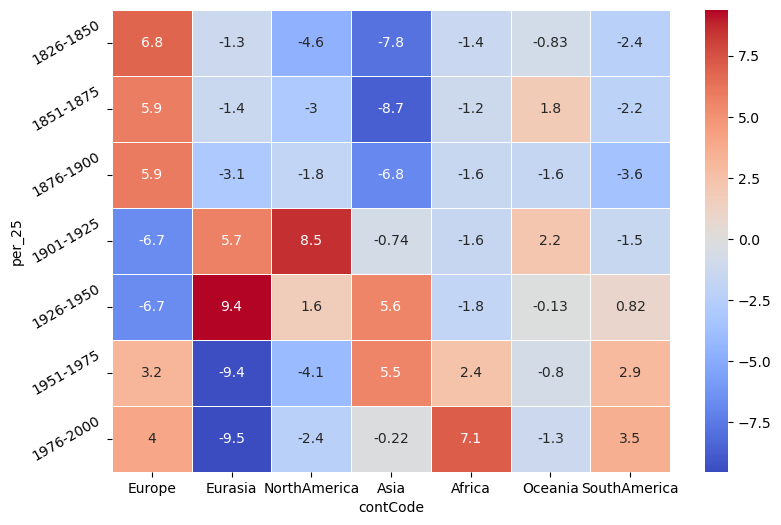

In [43]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [44]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1826-1850,63,97,6,2,8,5
1851-1875,105,201,24,5,25,12
1876-1900,135,329,83,7,17,12
1901-1925,498,1041,366,19,72,59
1926-1950,1000,1606,885,40,106,148
1951-1975,253,816,565,46,59,111
1976-2000,11,195,108,28,11,37


In [45]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 568.06 , dof : 30
p-value : 1.1881461634142798e-100
phi2 = inertie (variance totale) : 0.025169028853236415
Cramer:  0.11103062222450762


In [46]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1826-1850,630,6,63,97,5
1851-1875,940,24,105,201,12
1876-1900,1335,83,135,329,12
1901-1925,2160,366,498,1041,59
1926-1950,4348,885,1000,1606,148
1951-1975,3109,565,253,816,111
1976-2000,832,108,11,195,37


In [47]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 444.8 , dof : 6
p-value : 6.462563218564027e-93
phi2 = inertie (variance totale) : 0.019707503847864394
Cramer:  0.16984528117479006


## Continent et genre

In [48]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"United States, Israel, Canada","North America, Asia","academic, physicist","nuclear physics, cosmology, general relativity",NorthAmerica,1901-1925
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950


In [49]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,36,146,90,1236,495,32,87,2122
male,114,1906,2031,13074,3852,268,302,21547
Total,150,2052,2121,14310,4347,300,389,23669


### Créer la fonction

In [50]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [51]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,36,146,90,1236,495,32,87
male,114,1906,2031,13074,3852,268,302


Chi2 : 227.87 , dof : 6
p-value : 2.1829552552815577e-46
phi2 = inertie (variance totale) : 0.01009604582889911
Cramer:  0.09811863128801099


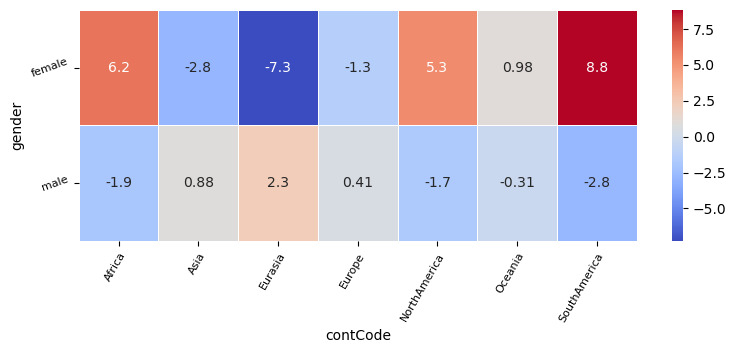

In [52]:
bivariee_stats(D)

### Genre et continent par époque

In [53]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"United States, Israel, Canada","North America, Asia","academic, physicist","nuclear physics, cosmology, general relativity",NorthAmerica,1901-1925,NorthAmerica_male
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male


In [54]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,1,7,0,10,4,225,0,4,0,0,0,1,252
1776-1800,0,1,0,3,0,18,6,280,0,17,0,2,0,1,328
1801-1825,0,2,0,7,0,28,3,442,4,43,0,2,0,3,534
1826-1850,0,2,0,6,0,63,11,619,7,90,0,8,0,5,811
1851-1875,0,5,0,24,2,103,33,907,23,178,2,23,0,12,1312
1876-1900,0,7,0,83,11,124,92,1243,45,284,1,16,0,12,1918
1901-1925,3,16,24,341,23,475,158,2002,75,966,6,66,13,46,4214
1926-1950,4,36,41,843,37,963,295,4052,120,1486,6,99,26,122,8130
1951-1975,14,32,54,511,15,238,424,2683,158,656,12,46,36,75,4954


In [55]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[6:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1901-1925,3,16,24,341,23,475,158,2002,75,966,6,66,13,46
1926-1950,4,36,41,843,37,963,295,4052,120,1486,6,99,26,122
1951-1975,14,32,54,511,15,238,424,2683,158,656,12,46,36,75
1976-2000,15,13,26,81,2,9,210,621,63,128,5,6,12,25


Chi2 : 1209.8 , dof : 39
p-value : 2.1232955134234553e-228
phi2 = inertie (variance totale) : 0.05360212864441971
Cramer:  0.14758629855670627


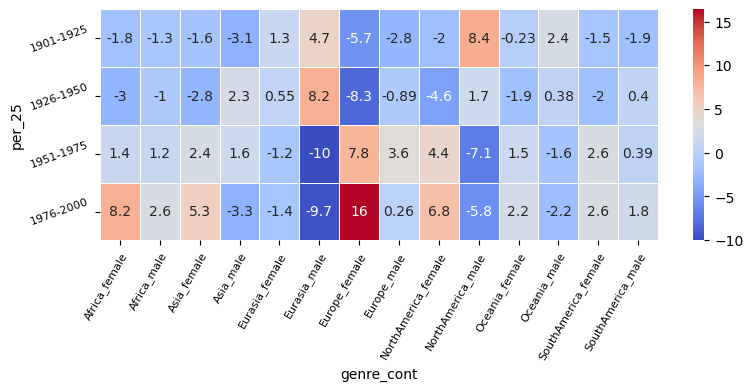

In [56]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [57]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

1236


In [58]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France            144
Germany           129
Poland            105
United Kingdom     88
Italy              88
Spain              71
Austria            44
Sweden             35
Finland            27
Slovenia           25
dtype: int64


In [59]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
Germany           27
Italy             27
United Kingdom    20
Spain             18
France            15
Poland            13
Russia             8
Hungary            7
Finland            7
Sweden             7
dtype: int64


In [60]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

34


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
1623,http://www.wikidata.org/entity/Q60143297,Katerina Falk,1984,female,"Czech Republic, Germany",Europe,"scientist, physicist","plasma, popular science, astrophysics, laser, ...",Europe,1976-2000,Europe_female
2391,http://www.wikidata.org/entity/Q96691414,Olena Karacheban,1990,female,Germany,Europe,"researcher, physicist",,Europe,1976-2000,Europe_female
4644,http://www.wikidata.org/entity/Q50923671,Kathy Ludge,1976,female,Germany,Europe,"physicist, university teacher",,Europe,1976-2000,Europe_female
4877,http://www.wikidata.org/entity/Q125267067,Dorit Glawion,1987,female,Germany,Europe,"researcher, astronomer",,Europe,1976-2000,Europe_female
5763,http://www.wikidata.org/entity/Q117234388,Anna Franckowiak,1983,female,Germany,Europe,"university teacher, physicist, researcher","neutrino, astrophysics, cosmic radiation",Europe,1976-2000,Europe_female


## Continent et discipline

In [61]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"United States, Israel, Canada","North America, Asia","academic, physicist","nuclear physics, cosmology, general relativity",NorthAmerica,1901-1925,NorthAmerica_male
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male


In [62]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [63]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male,physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female,physics
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,male,United Kingdom,Europe,"physicist, mathematician",,Europe,1901-1925,Europe_male,physics
3,http://www.wikidata.org/entity/Q61552351,Gerald E. Tauber,1922,male,"United States, Israel, Canada","North America, Asia","academic, physicist","nuclear physics, cosmology, general relativity",NorthAmerica,1901-1925,NorthAmerica_male,physics
4,http://www.wikidata.org/entity/Q95157297,Kristian Svoboda,1931,male,Czechoslovakia,Europe,"physicist, chemist, pharmacist",,Europe,1926-1950,Europe_male,physics


In [64]:
df_p.groupby('code_discipline').size()

code_discipline
astronomy     5811
physics      17873
dtype: int64

In [65]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,45,481,323,3343,1383,105,121,5801
physics,105,1571,1798,10967,2964,195,268,17868
Total,150,2052,2121,14310,4347,300,389,23669


In [66]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,0.8,8.3,5.6,57.6,23.8,1.8,2.1,100.0
physics,0.6,8.8,10.1,61.4,16.6,1.1,1.5,100.0
Total,0.6,8.7,9.0,60.5,18.4,1.3,1.6,100.0


In [67]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


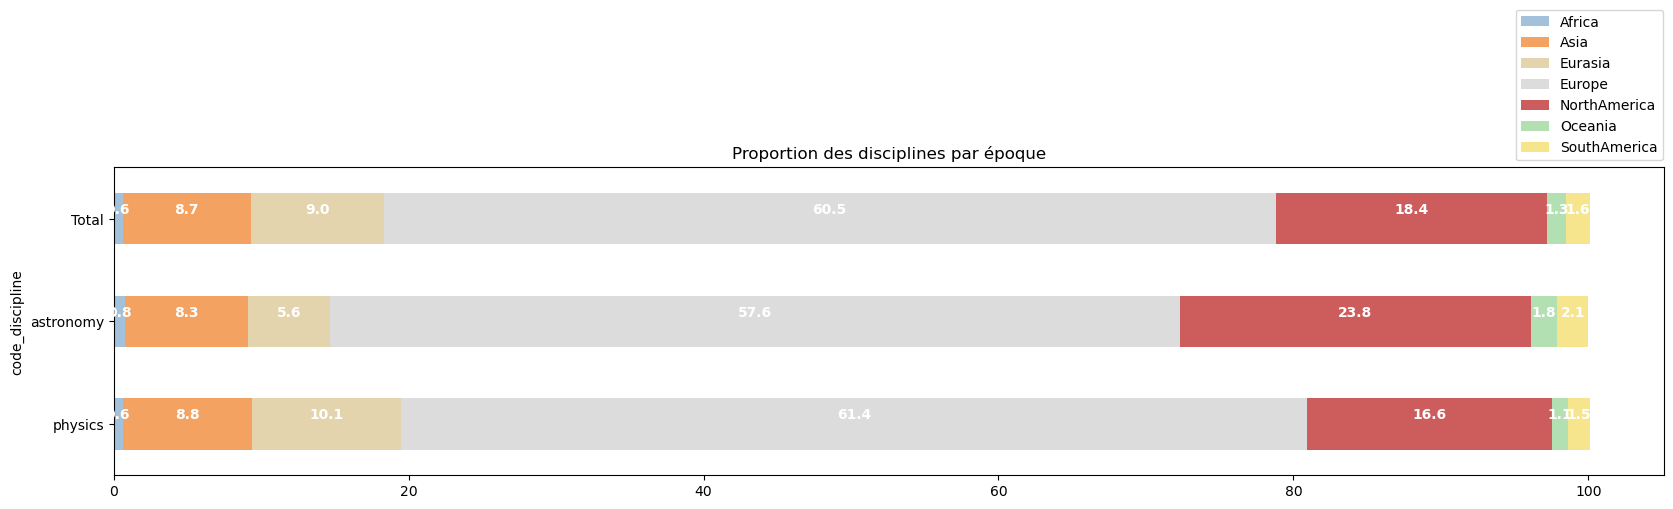

In [76]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [69]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
astronomy,45,481,323,3343,1383,105,121
physics,105,1571,1798,10967,2964,195,268


Chi2 : 265.03 , dof : 6
p-value : 2.5047376949356848e-54
phi2 = inertie (variance totale) : 0.01174273585793133
Cramer:  0.10581822458547405


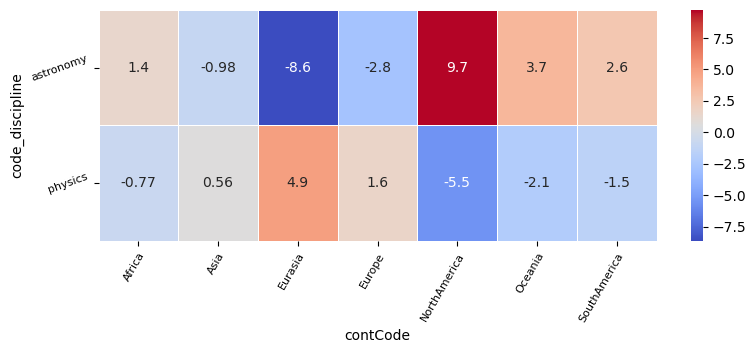

In [70]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [71]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male,physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female,physics


In [72]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,male,"Ukraine, Soviet Union","Europe, Asia",physicist,,Eurasia,1926-1950,Eurasia_male,physics,Eurasia_physics
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,female,"United States, India","North America, Asia","physicist, biophysicist",,NorthAmerica,1951-1975,NorthAmerica_female,physics,NorthAmerica_physics


In [73]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,8,0,3,7,124,105,2,2,0,0,1,0,252
1776-1800,1,0,3,0,13,5,143,143,10,7,2,0,0,1,328
1801-1825,2,0,6,1,17,11,193,252,33,14,2,0,3,0,534
1826-1850,2,0,4,2,26,37,262,368,69,28,8,0,3,2,811
1851-1875,4,1,9,15,36,69,357,583,109,92,16,9,5,7,1312
1876-1900,4,3,24,59,40,95,361,974,113,216,6,11,7,5,1918
1901-1925,7,12,60,305,76,422,443,1717,197,844,21,51,20,39,4214
1926-1950,10,30,183,701,92,908,647,3700,414,1192,20,85,28,120,8130
1951-1975,10,36,143,422,18,235,619,2488,351,463,22,36,32,79,4954


In [74]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


disc_cont,Africa_astronomy,Africa_physics,Asia_astronomy,Asia_physics,Eurasia_astronomy,Eurasia_physics,Europe_astronomy,Europe_physics,NorthAmerica_astronomy,NorthAmerica_physics,Oceania_astronomy,Oceania_physics,SouthAmerica_astronomy,SouthAmerica_physics
per_25,,,,,,,,,,,,,,
1876-1900,4,3,24,59,40,95,361,974,113,216,6,11,7,5
1901-1925,7,12,60,305,76,422,443,1717,197,844,21,51,20,39
1926-1950,10,30,183,701,92,908,647,3700,414,1192,20,85,28,120
1951-1975,10,36,143,422,18,235,619,2488,351,463,22,36,32,79
1976-2000,5,23,41,66,2,9,194,637,85,106,8,3,22,15


Chi2 : 1165.14 , dof : 52
p-value : 9.00803826971962e-210
phi2 = inertie (variance totale) : 0.05162350145451799
Cramer:  0.11939993020051194


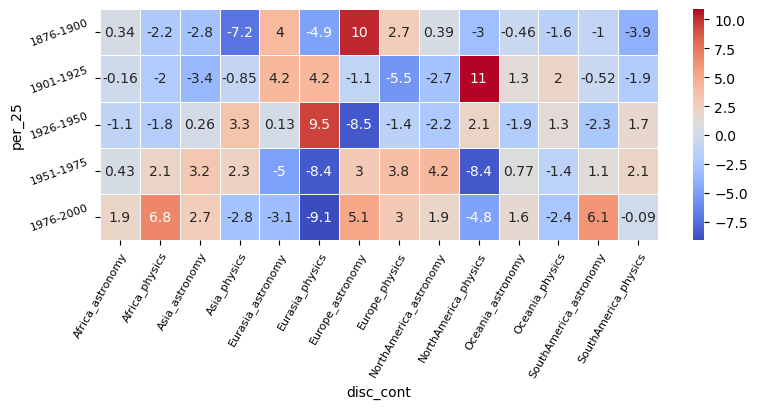

In [75]:
## Appliquer la fonction
bivariee_stats(D)